In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    SequentialEvaluator,
)
# from dike_model_function import DikeNetwork 
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant

warnings.filterwarnings("ignore")

In [2]:
import numpy as np


In [3]:
dike_model_1, planning_steps = get_model_for_problem_formulation(3)

zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})

pol0 = {}
#
for key in dike_model_1.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy("Policy 0", **pol0)

In [4]:
with MultiprocessingEvaluator(dike_model_1) as evaluator:
    results = evaluator.perform_experiments(scenarios=15000,policies=policy0,uncertainty_sampling=Samplers.LHS)

experiments, outcomes = results

100%|████████████████████████████████████| 15000/15000 [24:18<00:00, 10.28it/s]


In [5]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,82,255.217359,10.0,0.747259,187.064496,1.0,0.159582,328.761892,10.0,0.755331,...,0,0,0,0,0,0,0,0,Policy 0,dikesnet
1,46,60.186883,10.0,0.589140,33.106622,1.5,0.836434,59.566721,1.0,0.233067,...,0,0,0,0,0,0,0,1,Policy 0,dikesnet
2,126,122.373993,1.5,0.131073,100.265065,1.5,0.177987,72.118868,1.0,0.261573,...,0,0,0,0,0,0,0,2,Policy 0,dikesnet
3,84,105.842603,10.0,0.824441,321.620543,1.5,0.317561,278.894841,1.5,0.892210,...,0,0,0,0,0,0,0,3,Policy 0,dikesnet
4,26,74.814779,1.5,0.895899,165.181189,1.0,0.305736,284.629418,1.5,0.914887,...,0,0,0,0,0,0,0,4,Policy 0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,101,141.205513,10.0,0.508635,325.736131,1.0,0.462771,122.143596,1.5,0.376412,...,0,0,0,0,0,0,0,14995,Policy 0,dikesnet
14996,73,347.417760,1.0,0.104580,261.572663,1.0,0.953373,193.246899,1.0,0.901955,...,0,0,0,0,0,0,0,14996,Policy 0,dikesnet
14997,114,204.708586,10.0,0.593935,314.736946,1.0,0.998893,36.901384,10.0,0.694844,...,0,0,0,0,0,0,0,14997,Policy 0,dikesnet
14998,65,305.103633,1.0,0.262551,170.053503,10.0,0.436138,56.093856,10.0,0.196079,...,0,0,0,0,0,0,0,14998,Policy 0,dikesnet


In [6]:
df =pd.DataFrame(outcomes)

In [7]:
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
    "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]
df["Expected Annual Damage"] = df["A.1_Expected Annual Damage"] + df["A.2_Expected Annual Damage"] + df["A.3_Expected Annual Damage"] + df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"]

outcomes["Expected Number of Deaths"] = df["Expected Number of Deaths"]
outcomes["Expected Annual Damage"] = df["Expected Annual Damage"]

## Feature importance (not required but nice to know)

In [8]:

df_feature_importance_out = df[["Expected Annual Damage", "Expected Number of Deaths", "A.5_Expected Number of Deaths","A.5_Expected Annual Damage","Expected Evacuation Costs"]]


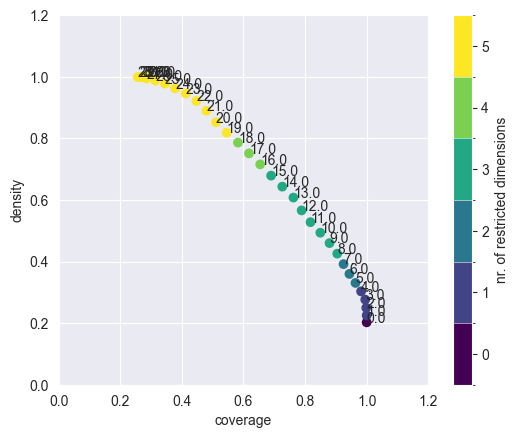

In [9]:
x = experiments

y = ((df_feature_importance_out["A.5_Expected Number of Deaths"] > list(np.sort(df_feature_importance_out["A.5_Expected Number of Deaths"]))[np.int64(0.80* len(df_feature_importance_out["A.5_Expected Number of Deaths"]))])
    |(df_feature_importance_out['A.5_Expected Annual Damage'] > list(np.sort(df_feature_importance_out['A.5_Expected Annual Damage']))[np.int64(0.80* len(df_feature_importance_out['A.5_Expected Annual Damage']))])
     )

prim_alg = prim.Prim(x, y, threshold=0.8,peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

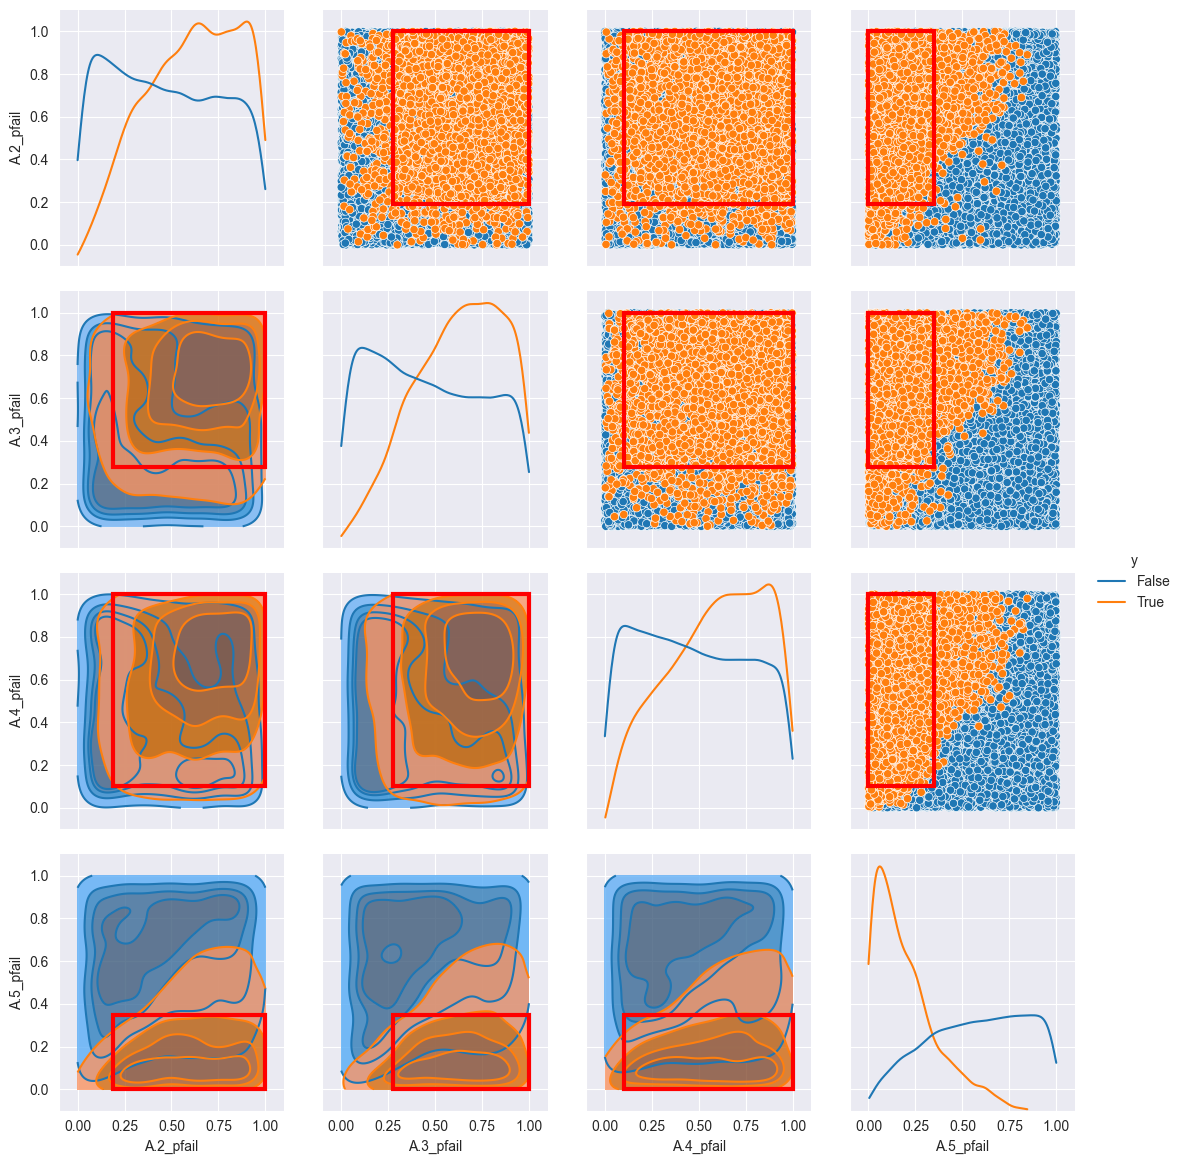

In [10]:
box1.select(16)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

coverage       0.654264
density        0.715520
id            16.000000
k           1987.000000
mass           0.185133
mean           0.715520
n           2777.000000
res_dim        4.000000
Name: 16, dtype: float64

             box 16                                 
                min       max      qp value qp value
A.5_pfail  0.000016  0.348076           NaN      0.0
A.3_pfail  0.275887  0.999981  2.674797e-48      NaN
A.2_pfail  0.190144  0.999949  2.204492e-24      NaN
A.4_pfail  0.102819  0.999954  1.607439e-05      NaN


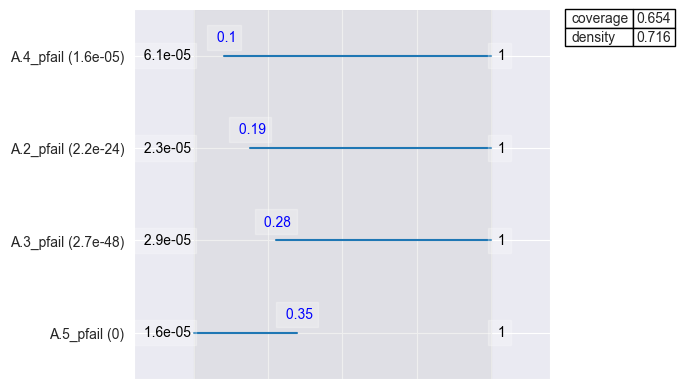

In [11]:
box1.inspect(16)
box1.inspect(16, style="graph")
plt.show()  

In [12]:
box1.inspect(16, style='data')[0][1]

box 16                                 
                min       max      qp value qp value
A.5_pfail  0.000016  0.348076           NaN      0.0
A.3_pfail  0.275887  0.999981  2.674797e-48      NaN
A.2_pfail  0.190144  0.999949  2.204492e-24      NaN
A.4_pfail  0.102819  0.999954  1.607439e-05      NaN

In [13]:
pd.DataFrame(box1.inspect(16, style='data')[0][1]).to_csv('data\para_space_A5.csv')

### PRIM for general outcomes 

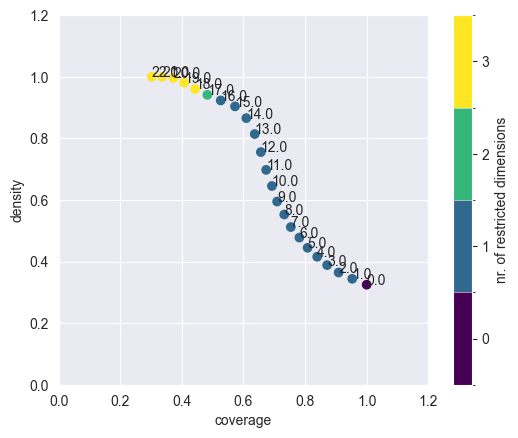

In [14]:
y = (
    (df_feature_importance_out['Expected Number of Deaths'] > list(np.sort(df_feature_importance_out["Expected Number of Deaths"]))[np.int64(0.8* len(df_feature_importance_out['Expected Number of Deaths']))])
     |(df_feature_importance_out['Expected Annual Damage'] > list(np.sort(df_feature_importance_out["Expected Annual Damage"]))[np.int64(0.8* len(df_feature_importance_out['Expected Annual Damage']))])
     )
# (df_feature_importance_out["Total Costs"] >= list(np.sort(df_feature_importance_out["Total Costs"]))[int(0.80* len(df_feature_importance_out["Total Costs"]))]) 
#      |
prim_alg = prim.Prim(x, y, threshold=0.95,peel_alpha=0.1)
box2 = prim_alg.find_box()
box2.show_tradeoff(annotated=True)
plt.show()

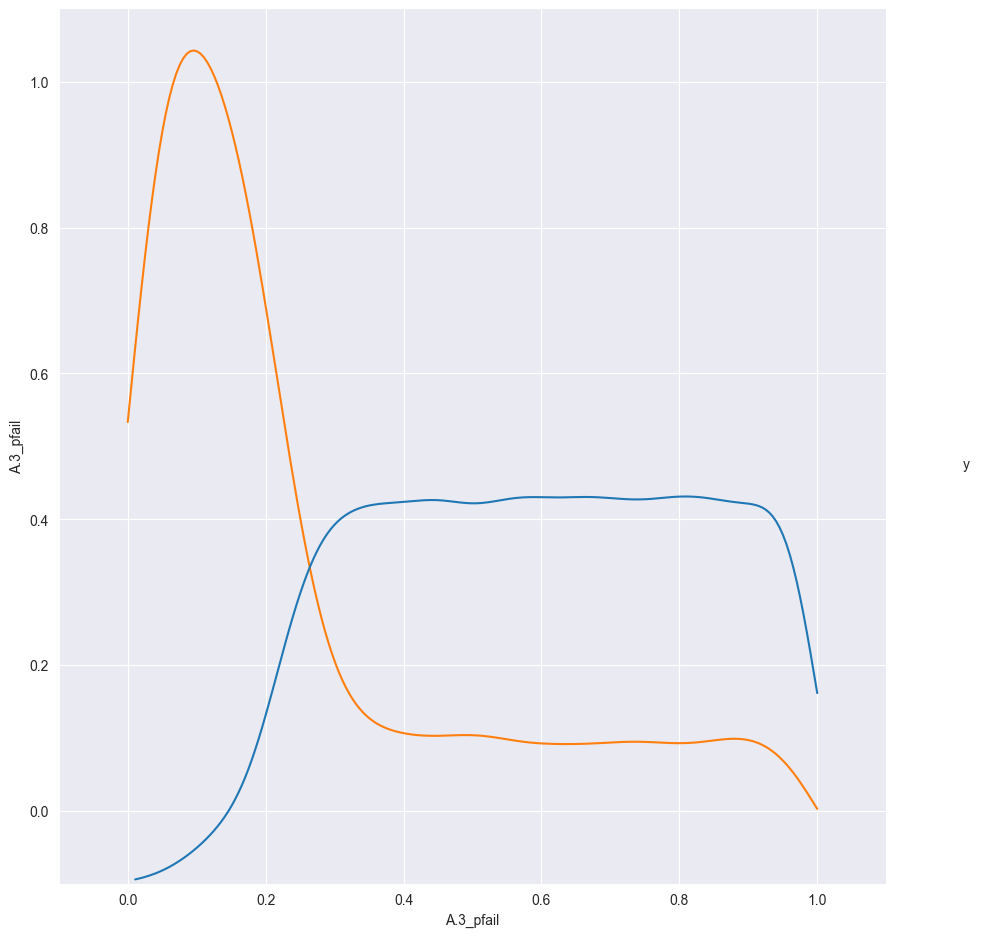

In [15]:
box2.select(12)
box2.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.show()


coverage       0.656539
density        0.755314
id            12.000000
k           3198.000000
mass           0.282267
mean           0.755314
n           4234.000000
res_dim        1.000000
Name: 12, dtype: float64

             box 12                            
                min       max qp value qp value
A.3_pfail  0.000029  0.282267      NaN      0.0


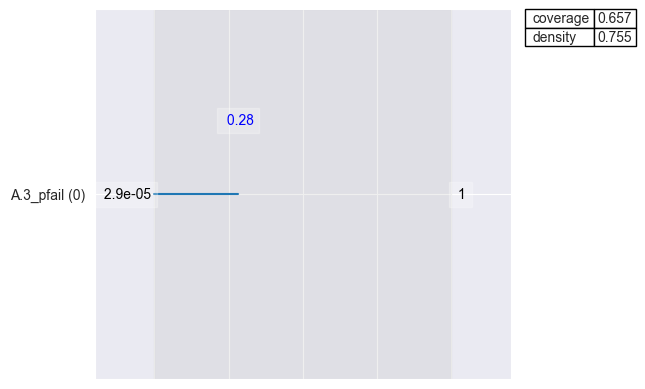

In [16]:
box2.inspect(12)
box2.inspect(12, style="graph")
plt.show()

In [17]:
a=box2.inspect(12)
type(box1)

coverage       0.656539
density        0.755314
id            12.000000
k           3198.000000
mass           0.282267
mean           0.755314
n           4234.000000
res_dim        1.000000
Name: 12, dtype: float64

             box 12                            
                min       max qp value qp value
A.3_pfail  0.000029  0.282267      NaN      0.0


ema_workbench.analysis.prim.PrimBox

In [18]:
box2.inspect(12, style='data')[0][0]

coverage       0.656539
density        0.755314
id            12.000000
k           3198.000000
mass           0.282267
mean           0.755314
n           4234.000000
res_dim        1.000000
Name: 12, dtype: float64

In [19]:
pd.DataFrame(box2.inspect(12, style='data')[0][1]).to_csv('data\para_space_all.csv')

In [21]:
from Convience_fun import create_scenario
import multirange as mr

df_param_space_A5 = (pd.read_csv('data/para_space_A5.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"}))
df_param_space_all = (pd.read_csv('data/para_space_all.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"}))

# pd.read_csv('data/para_space_all.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"})

dike_model, planning_steps = get_model_for_problem_formulation(3)


def create_scenario_from_box(all, a5):
    para_list = []
    for uncertainty in dike_model.uncertainties:
        # print((variable in df_param_space_A5.Variable))
        variable = uncertainty.name
        # print(variable)
        if (variable in list(df_param_space_A5.Variable)) & (variable in list(df_param_space_all.Variable)) & (
                all + a5 == 2):
            min_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[1]].values[
                    0]) * 10000
            max_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[2]].values[
                    0]) * 10000

            min_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[1]].values[
                    0]) * 10000
            max_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[2]].values[
                    0]) * 10000

            boundaries = mr.overlap(range(int(min_1), int(max_1)), range(int(min_2), int(max_2)))
            para_list.append((boundaries.start + (boundaries.stop - boundaries.start) / 2) / 10000)
            print((boundaries.start + (boundaries.stop - boundaries.start) / 2) / 10000)
        elif (variable in list(df_param_space_A5.Variable)) & (a5 == True):
            min_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[1]].values[0])
            max_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[2]].values[0])

            para_list.append((min_1 + (max_1 - min_1) / 2))
        elif (variable in list(df_param_space_all.Variable)) & (all == True):
            min_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[1]].values[0])
            max_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[2]].values[0])

            para_list.append((min_2 + (max_2 - min_2) / 2))
        elif variable.startswith("d"):
            para_list.append(3.5)
        elif variable == "A.0_ID flood wave shape":
            para_list.append(17)
        elif variable.endswith("Brate"):
            para_list.append(1.5)
        else:
            para_list.append((uncertainty.lower_bound + (uncertainty.upper_bound - uncertainty.lower_bound) / 2))

    return create_scenario(para_list)


Scenarios_MOEA = [create_scenario_from_box(all=True, a5=True), create_scenario_from_box(all=True, a5=False),
                  create_scenario_from_box(all=False, a5=True)]
import pickle

with open("data\ScenariosOpenExplo", 'wb') as file:
    pickle.dump(Scenarios_MOEA, file) 



0.279
